In [4]:
from __future__ import division
from IPython.core.display import Image

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score


# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Intro to Sentiment Analysis
Week 8| Lesson 5.1

### LEARNING OBJECTIVES
*After this lesson, you will be able to:*
- Understand basic approaches to sentiment analysis
- Implement simplified sentiment analysis using inverters, incrementers, decrementers
- Use a sentiment analyzer from NLKT

## Reminder: what have we already looked at?

## What have we still not really addressed?

Many, many things...

Including sentiment!  Is the text expressing positive, negative or neutral ideas?

"This is crazy good"

"This is crazy"

"I am happy"

"I am so happy"

"I am so not happy"

"I am ever so slightly happy"


It's tricky...

What problems might we encounter?

## How might we approach calculating the sentiment of a piece of text?

1) Use pre-labelled documents and use their labels and features to learn about sentiment

2) Use pre-labelled words and use their sentiment to categorize documents

## Use pre-labelled documents and use their labels and features to learn about sentiment

NLKT provides a set of corpora for use, including a pre-labelled corpus of 2000 movie reviews.

In [5]:
df = pd.read_csv("./assets/datasets/revs.csv")
df.head()

,review,sentiment
0,films adapted from comic books have had plenty...,pos
1,every now and then a movie comes along from a ...,pos
2,you've got mail works alot better than it dese...,pos
3,""" jaws "" is a rare film that grabs your attent...",pos
4,moviemaking is a lot like being the general ma...,pos


## Let's do some feature extraction on the text to try to predict whether films are positive or negative

In [6]:
cv = CountVectorizer(min_df=25, stop_words='english')
cv.fit(df['review'])
word_df = pd.DataFrame(cv.transform(df['review']).todense(), columns = cv.get_feature_names())
word_df.head()

,000,10,100,11,12,13,14,15,16,17,...,yeah,year,years,yes,york,young,younger,youth,zero,zone
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## Let's build a simple classification model using logistic regression

In [7]:
lr = LogisticRegression()
y = df['sentiment'].apply(lambda x: 1 if x=='pos' else 0)
X = word_df.values
cross_val_score(lr, X, y)

array([ 0.82784431,  0.83483483,  0.82882883])

The model predicts with ~82% accuracy which is pretty great!

## Let's do a train test split, and see which reviews our model predicts as the least and most likely to be negative

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.30,
                                                        random_state=14)
lr.fit(X_train, y_train)
preds = lr.predict_proba(X_test)[:,0]

In [9]:
pred_df = y_test.reset_index()
pred_df['prob'] = preds
pred_df.sort_values('prob').head()

,index,sentiment,prob
74,345,1,5.823519e-11
311,862,1,3.678860e-09
402,433,1,4.077185e-09
388,556,1,7.257252e-09
114,922,1,2.684623e-08


Film number 345 is the least likely to be negative according to our model

In [10]:
print df.loc[345,'sentiment']
print df.loc[345,'review']

pos
alien 3 is the only alien film i have seen in theaters . i saw it when i was 13 years old , and i must admit that i didn't like it . of course , i was expecting aliens again , and i believe this was my fault . in order to appreciate alien 3 , you need to see aliens , but you also have to wipe away all the expectations from its predecessor . james cameron's aliens was an action film , and many people consider it the best in the series . i am among that group , but alien 3 is an extremely entertaining film , which critics have bashed for its originality . many thought the final chase scene went on for too long , and many others thought that the film was too much dialogue and not enough action . both are untrue , because the film has quite a bit of action , and the dialogue was essential and well - written . as for the chase sequence , it was long , but not overly long , creating quite a bit of suspense from confusion . perhaps watching alien 3 on video helped . on the big screen , i 

In [11]:
pred_df.sort_values('prob').tail()

,index,sentiment,prob
547,1772,0,0.999996
482,1367,0,0.999999
374,1676,0,1.000000
176,1766,0,1.000000
384,1807,0,1.000000


Film number 1772 is the most likely to be negative according to our model

In [12]:
print df.loc[1772,'sentiment']
print df.loc[1772,'review']

neg
it happens every year -- the days get longer , the weather gets warmer and the studios start releasing their big - budget blockbusters . this year's crop already seems inferior to that of past summers , even 1997's lackluster trio of batman & robin , the fifth element and the lost world . the marketing blitz in 1998 has been centered on godzilla ( " heeere , lee - zerd , lee - zerd . . . " ) , which doesn't make me optimistic about future summers . godzilla is , of course , based on a series of cult movies ( translation : really bad movies only a few people can tolerate ) from japan that turn up really late at night on ted turner - owned cable stations . that this big - budget remake won't rise above its roots is fairly obvious . the credits show us the origin of godzilla . in five words : nuclear explosion creates giant lizard . sounds like an enquirer headline , doesn't it ? the mushroom cloud is followed by the inevitable " discovery " sequence . this time , a japanese guy is ea

Add predicting the most likely bad review...

Add ratios!

## Let's say we want to know which words are most associated with good / bad reviews.  How might we do that?

We could count how many times a particular word appears in a positive review, and how many times it appears in a negative review, and measure the difference.

In [13]:
def count_word(x):
    '''Return number of postive / negative reviews which mention x'''
    pos = []
    neg = []
    for rev, sentiment in zip(df['review'], df['sentiment']):
        if x in rev and sentiment=="pos":
            pos.append(x)
        elif x in rev and sentiment=="neg":
            neg.append(x)
    return len(pos), len(neg)

In [14]:
feature_df = pd.DataFrame()
feature_df['words'] = cv.get_feature_names()
feature_df['ratio'] = feature_df['words'].apply(count_word)
feature_df['pos'] = feature_df['ratio'].apply(lambda x: x[0])
feature_df['neg'] = feature_df['ratio'].apply(lambda x: x[1])
feature_df.head()

,words,ratio,pos,neg
0,000,"(65, 85)",65,85
1,10,"(145, 175)",145,175
2,100,"(45, 43)",45,43
3,11,"(25, 26)",25,26
4,12,"(41, 32)",41,32


## Words most associated with negative reviews

In [15]:
feature_df['net'] = feature_df['pos'] - feature_df['neg']
feature_df.sort_values('net').head()

,words,ratio,pos,neg,net
274,bad,"(280, 545)",280,545,-265
3603,waste,"(44, 202)",44,202,-158
3692,worst,"(44, 194)",44,194,-150
2452,plot,"(426, 576)",426,576,-150
3198,stupid,"(41, 186)",41,186,-145


## Words most associated with positive reviews

In [16]:
feature_df.sort_values('net').tail()

,words,ratio,pos,neg,net
1931,life,"(517, 378)",517,378,139
2393,perform,"(521, 377)",521,377,144
2390,perfect,"(278, 125)",278,125,153
2394,performance,"(480, 321)",480,321,159
1467,great,"(485, 320)",485,320,165


## But this required prelabelled documents...

## Let's use pre-labelled words

There are many corpora online which include words and their associated sentiment (again, though, this is subjective)

In [17]:
sent_words = pd.read_csv("./assets/datasets/sent_words.csv")
sent_words.head()

,POS,PosScore,NegScore,word
0,a,0.125,0.00,able
1,a,0.000,0.75,unable
2,a,0.000,0.00,dorsal
3,a,0.000,0.00,ventral
4,a,0.000,0.00,acroscopic


## For now, we're going to ignore piece of speech...

To speed up computation, let's create a dictionary that has the word as the key, and the postivity / negativity scores as the values

In [18]:
sen_agg_dict = {}
for i, row in enumerate(sent_words.itertuples()):
    sen_agg_dict[row[4]] = {'pos_score':row[2], 'neg_score':row[3]}
    
sen_agg_dict['grotesque']

{'neg_score': 0.125, 'pos_score': 0.0}

## Scoring our sentences

Let's create a function that will provide the sentiment score for each word in a sentence.  

We're also going to add the notion of "objectivity" which we'll define as:

1 - (positive_score + negative_score)


In [19]:
def agg_scorer(x):
    x = x.split()
    pos_scores, neg_scores, obj_scores = [], [], []
    for token in x:
        try:
            pos_scores.append(sen_agg_dict[token]['pos_score'])
            neg_scores.append(sen_agg_dict[token]['neg_score'])
            obj_scores.append((1. - (pos_scores[-1] + neg_scores[-1])))
        except:
            pos_scores.append(0.)
            neg_scores.append(0.)
            obj_scores.append(1.)
    return [pos_scores, neg_scores, obj_scores]

agg_scorer("Why does everyone hate linear algebra?")

[[0.0, 0.0, 0.0, 0.0, 0.25, 0.0],
 [0.0, 0.0, 0.0, 0.75, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.25, 0.75, 1.0]]

In [20]:
score_list = []
for rev in df['review']:
    score_list.append(agg_scorer(rev))
df['scores'] = score_list
df.head()

,review,sentiment,scores
0,films adapted from comic books have had plenty...,pos,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0...."
1,every now and then a movie comes along from a ...,pos,"[[0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
2,you've got mail works alot better than it dese...,pos,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,""" jaws "" is a rare film that grabs your attent...",pos,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,moviemaking is a lot like being the general ma...,pos,"[[0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0...."


## Let's create features which are the average postive, negative and neutral sentiment


In [21]:
df['avg_pos'] = df['scores'].apply(lambda x: np.mean(x[0]))
df['avg_neg'] = df['scores'].apply(lambda x: np.mean(x[1]))
df['avg_neu'] = df['scores'].apply(lambda x: np.mean(x[2]))
df.head()

,review,sentiment,scores,avg_pos,avg_neg,avg_neu
0,films adapted from comic books have had plenty...,pos,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0....",0.017549,0.020782,0.961669
1,every now and then a movie comes along from a ...,pos,"[[0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",0.020833,0.021955,0.957212
2,you've got mail works alot better than it dese...,pos,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.037672,0.026545,0.935782
3,""" jaws "" is a rare film that grabs your attent...",pos,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.017103,0.027555,0.955342
4,moviemaking is a lot like being the general ma...,pos,"[[0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0....",0.013065,0.014677,0.972258


## Let's see how well we can classify positive vs negative films

In [22]:
X = df[['avg_pos', 'avg_neg', 'avg_neu']]
lr = LogisticRegression()
cross_val_score(lr, X, y)


array([ 0.59730539,  0.57807808,  0.65615616])

This doesn't perform as well as the first approach... why not?

## Let's look back at our original examples:

"This is crazy good"

"This is crazy"

"I am happy"

"I am so happy"

"I am so not happy"

"I am ever so slightly happy"

## What can we do to improve our model?

## Let's define a list of inverters, incrementers and decrementers.

Inverters will flip the sentiment

Amplifiers will double the sentiment

Attenuators will halve the sentiment

In [23]:
inverters = ['not', 'lacked', "isn't", "wasn't", "hasn't"]
amplifiers = ['very', 'extremely', 'more', 'too', 'greater']
attenuators = ['barely', 'little', 'few', 'slightly']

## Let's change our scoring function to take these into account

In [24]:
def agg_scorer2(x):
    x = x.split()
    pos_scores, neg_scores, obj_scores = [], [], []
    for i, token in enumerate(x):
        try:
            if x[i-1] in inverters:
                pos_scores.append(sen_agg_dict[token]['pos_score']*-1)
                neg_scores.append(sen_agg_dict[token]['neg_score']*-1)
                obj_scores.append((1. - (pos_scores[-1] + neg_scores[-1])))
            elif x[i-1] in amplifiers:
                pos_scores.append(sen_agg_dict[token]['pos_score']*2)
                neg_scores.append(sen_agg_dict[token]['neg_score']*2)
                obj_scores.append((1. - (pos_scores[-1] + neg_scores[-1])))
            elif x[i-1] in attenuators:
                pos_scores.append(sen_agg_dict[token]['pos_score']*0.5)
                neg_scores.append(sen_agg_dict[token]['neg_score']*0.5)
                obj_scores.append((1. - (pos_scores[-1] + neg_scores[-1])))          
            else:
                pos_scores.append(sen_agg_dict[token]['pos_score'])
                neg_scores.append(sen_agg_dict[token]['neg_score'])
                obj_scores.append((1. - (pos_scores[-1] + neg_scores[-1])))  
        except:
            pos_scores.append(0.)
            neg_scores.append(0.)
            obj_scores.append(1.)
    return [pos_scores, neg_scores, obj_scores]

In [25]:
score_list = []
for rev in df['review']:
    score_list.append(agg_scorer2(rev))
df['scores'] = score_list
df['avg_pos'] = df['scores'].apply(lambda x: np.mean(x[0]))
df['avg_neg'] = df['scores'].apply(lambda x: np.mean(x[1]))
df['avg_neu'] = df['scores'].apply(lambda x: np.mean(x[2]))
df.head()

,review,sentiment,scores,avg_pos,avg_neg,avg_neu
0,films adapted from comic books have had plenty...,pos,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0....",0.016549,0.020551,0.962900
1,every now and then a movie comes along from a ...,pos,"[[0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",0.020032,0.021955,0.958013
2,you've got mail works alot better than it dese...,pos,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.038465,0.026017,0.935518
3,""" jaws "" is a rare film that grabs your attent...",pos,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.017103,0.028083,0.954814
4,moviemaking is a lot like being the general ma...,pos,"[[0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0....",0.012742,0.014677,0.972581


## Let's see if our model is better...

In [26]:
X = df[['avg_pos', 'avg_neg', 'avg_neu']]
lr = LogisticRegression()
cross_val_score(lr, X, y)

array([ 0.61826347,  0.59309309,  0.66366366])

It's a little better!

But still not as good as training on the reviews.

## Other options!

## There are some excellent pre-trained sentiment analyzers you can also use, including...

## VADER

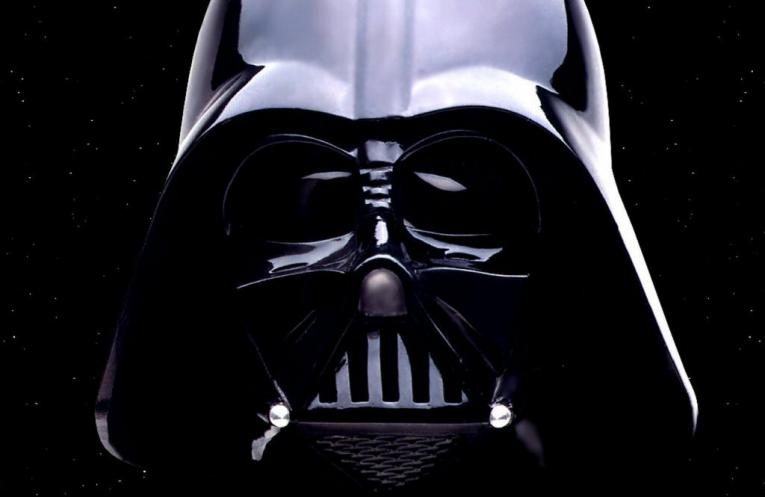

In [27]:
Image('http://the-indie-pendent.com/wp-content/uploads/2016/06/darth-vader-face1.jpg')

## Not quite.

## Valence Aware Dictionary for sEntiment Reasoning

[background](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf)

Vader is specially tuned to microblogging.

In [28]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
tweet = "Arnold Schwarzenegger isn't voluntarily leaving the Apprentice, he was fired by his bad (pathetic) ratings, not by me. Sad end to great show"
print tweet
sia.polarity_scores(tweet)

Arnold Schwarzenegger isn't voluntarily leaving the Apprentice, he was fired by his bad (pathetic) ratings, not by me. Sad end to great show


/Users/pt/anaconda/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


{'compound': -0.1144, 'neg': 0.217, 'neu': 0.58, 'pos': 0.203}

## VADER is just the tip of the iceberg....

There are many other pre-trained / pre-structured text analysis tools

## Conclusion

In this lesson we learned some of the basics of sentiment analysis including:
- pre-labelled corpus of documents
- pre-labelled corpus of words

There are many, many more text analysis tools available for use (including the very powerful [gensim](http://radimrehurek.com/gensim/tutorial.html))